In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

*The goal of our project is to analyze metadata from messaging groups in order to gain insights about the information being exchanged.*<br> *To accomplish this, we recorded the traffic from four different WhatsApp Web groups, each exhibiting distinct characteristics:*

*Group A: Only picture messages were sent within this group.<br>
Group B: Only long text messages were exchanged in this group.<br>
Group C: This group contained only video file transfers between members.<br>
Group D: Audio files were the sole media type sent in this group.<br>
This diversity in group traffic composition allowed us to analyze whether unique fingerprints emerged in the timing and size patterns for different content types.<br>*

*Additionally, we captured a second dataset from Group A. In this new capture, while still only sending pictures, we added background "noise" by streaming music on Spotify concurrently.<br> By comparing this noisy capture to the initial clean Group A traffic, we could examine the impact of mixed media streams on identifying underlying messaging patterns.<br>*

*We also captured a third dataset from different groups mixed together.In this new capture we sent two pictures, one video and one long message.<br> We tried to understand from this how different times look next to each other.*

In [317]:
def plot_graph(data_frame, graph_title):
    """
    Plot a stem graph using data from the provided DataFrame.
    """
    # Extract data from the DataFrame
    time_values = data_frame['Time']
    length_values = data_frame['Length']
    
    # Create a new figure
    plt.figure(figsize=(15, 6)) 
    
    # Plot the stem graph
    plt.stem(time_values, length_values, linefmt='black', markerfmt=' ', basefmt='black')
    
    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.title(graph_title, fontsize=15)
    
    # Display the graph
    plt.show()

In [358]:
def compute_pdf(data_frame, bins=10):
    """
    Calculate the Probability Density Function (PDF) for inter-arrival time.
    """
    delays = data_frame['Time'].diff().shift(-1).dropna()
    
    # Create a histogram of inter-arrival times
    counts, bin_boundaries = np.histogram(delays, bins=bins, density=True)
    
    # Normalize counts to get PDF values
    pdf_values = counts / sum(counts)
    
    return bin_boundaries, pdf_values

In [359]:
def custom_exponential(x, lambda_val, scaling):
    res = scaling * lambda_val * np.exp(-lambda_val * x)
    return res

def visualize_interarrival_pdf(data_frame, edges, pdf_vals):
    inter_delays = data_frame['Time'].diff().shift(-1).dropna()
    
    plt.figure(figsize=(6, 3))
    
    plt.hist(bin_edges[:-1], bins=bin_edges, weights=pdf,color='blue', histtype='step', linewidth=2,label='Histogram of Inter Message Delays')
    
    estimated_lambda = 1. / np.mean(inter_delays)
    
    bin_w = edges[1] - edges[0]
    max_pdf_val = max(pdf_vals)
    scaling_factor = max_pdf_val / (estimated_lambda * np.exp(-estimated_lambda * edges[np.argmax(pdf_vals)]))
    
    fitted_x = np.linspace(0, max(edges), 500)
    
    fitted_y = custom_exponential(fitted_x, estimated_lambda, scaling_factor)
    
    plt.plot(fitted_x, fitted_y, color='red', lw=2, label='Fitted Exponential Distribution')
    
    plt.xlabel('Inter-Arrival Time')
    plt.ylabel('PDF')
    plt.title('PDF of Inter-Arrival Time and Fitted Exponential Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

In [360]:
def plot_hist(data_frame, max_range, graph_title):
    """
    Plot a histogram of the given data within the specified range.
    """
    
    data_diff = data_frame['Time'].diff().shift(-1)
    
    bins = range(0, max_range) 
    plt.figure(figsize=(6,3)) 
    
    # Plot histogram
    plt.hist(data_diff, bins=bins, color='yellow', edgecolor='black')
    
    # Labels and title
    plt.xlabel('Time Difference')
    plt.ylabel('Frequency')
    plt.title(graph_title)
    
    # Show plot
    plt.show()

In [408]:
def plot_main_and_sub_graph(main_data_frame, sub_data_frame, graph_title,sub_title1, sub_title2):
    """
    Plot a stem graph using data from the provided main DataFrame and sub DataFrame.
    Main DataFrame will be plotted in red, and sub DataFrame will be plotted in blue.
    """
    # Extract data from the main DataFrame
    main_time_values = main_data_frame['Time']
    main_length_values = main_data_frame['Length']
    
    # Extract data from the sub DataFrame
    sub_time_values = sub_data_frame['Time']
    sub_length_values = sub_data_frame['Length']
    
    # Create a new figure
    plt.figure(figsize=(15, 6))
    
    # Plot the main data in red
    plt.stem(main_time_values, main_length_values, linefmt='tomato', markerfmt=' ', basefmt='tomato')
    
    # Plot the sub data in blue
    plt.stem(sub_time_values, sub_length_values, linefmt='cornflowerblue', markerfmt=' ', basefmt='cornflowerblue')
    
    # Set labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.title(graph_title, fontsize=15)
    plt.legend([sub_title1,sub_title2])
    # Display the graph
    plt.show()

*After capturing the data and filtering on tcp.port=443, we tried to understand how we could further filter the data to obtain the relevant packets.<br> Therefore, we decided to filter the data based on the IP address of our computer and the IP address of the WhatsApp web server.<br>*

*By only looking at packets sent between our computer and the WhatsApp server, we aimed to isolate the metadata specific to our WhatsApp web usage.<br> This should allow us to analyze messaging patterns, message frequency, and other relevant metrics for our account.<br>*

*Filtering out other extraneous network traffic that is not related to our WhatsApp web session helps reduce noise in the data and lets us focus our analysis specifically on our own WhatsApp messaging metadata.*
<br> 

### Pictures Group

## אבי - צריך לקרוא ולתקן 

In this group,the dataset contains packet captures during image file transfers. Initial recordings contained substantial noise from unrelated network traffic, making analysis difficult. To better isolate the image packets, multiple photos were transmitted together in succession.

As seen in the figure, this approach allowed the image packets to emerge as a distinctive sawtooth pattern above the noise. The clusters of large, regular peaks correspond to the burst of packets for each individual photo being sent.

Sending files in dense groups proves effective for identifying data type patterns amidst noisy networks. The resulting fingerprints are pronounced compared to those for single files. Going forward, collections of images and text can be transmitted together to accentuate their traffic signatures for more robust analysis.

Isolation from noise will facilitate matching unknown packets to known data types using their characteristic patterns. Further work is needed to determine optimal transmission strategies to highlight fingerprints for broader data types like video. Overall, clustering related data enables cleaner extraction of the salient features unique to that form of traffic.

In [409]:
pictures_data = pd.read_csv("../resources/Pictures Group/pictures_data.csv")
# pictures_data = pictures_data.loc[pictures_data['Length'] > 200] 
pictures_data = pictures_data.loc[
    (pictures_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (pictures_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
pictures_data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
1,5,9.821193,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=1 Ack=1 Win=1364 Len=1...
2,6,9.821505,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,164,Application Data
5,13,10.045411,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=1457 Ack=71 Win=1364 L...
6,14,10.114095,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
8,16,10.127036,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=1529 Ack=71 Win=1364 L...


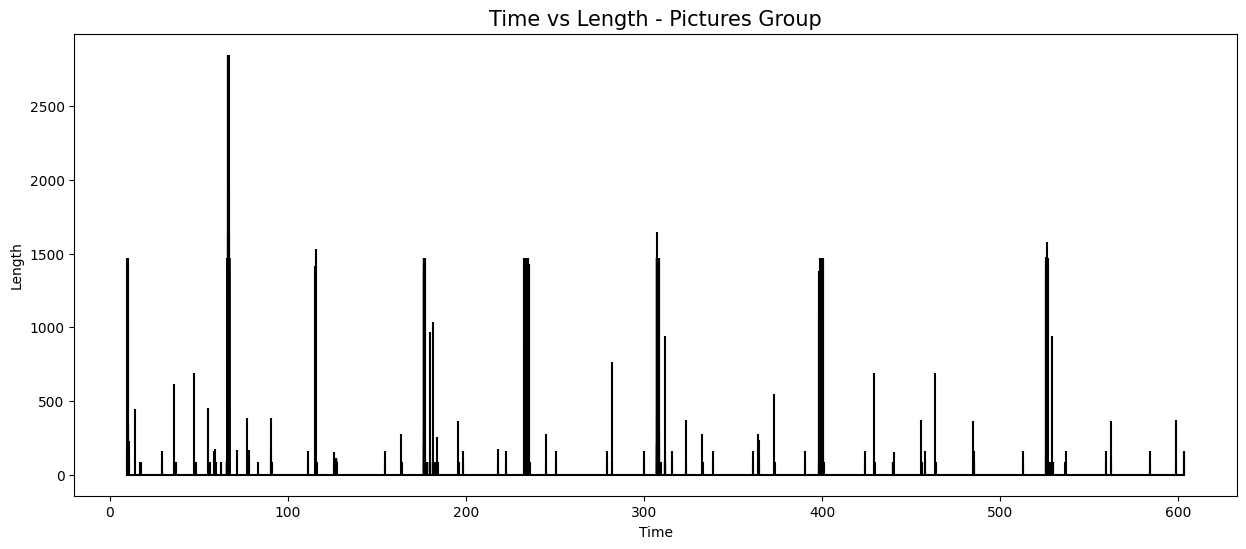

In [410]:
plot_graph(pictures_data,'Time vs Length - Pictures Group')

*In order to differentiate noise from actual image data, we conducted an experiment three times where a single image was transmitted through a messaging group.<br>
By analyzing the resulting packet size distributions, it was determined that packets smaller than 200 bytes in size did not contain any meaningful image data and could be classified as noise.* 

In [411]:
picture_check1 = pd.read_csv("../resources/Picture threshold//picture_check1_data.csv", encoding='latin-1')

picture_check2 = pd.read_csv("../resources/Picture threshold/picture_check2_data.csv", encoding='latin-1')

picture_check3 = pd.read_csv("../resources/Picture threshold/picture_check3_data.csv", encoding='latin-1')

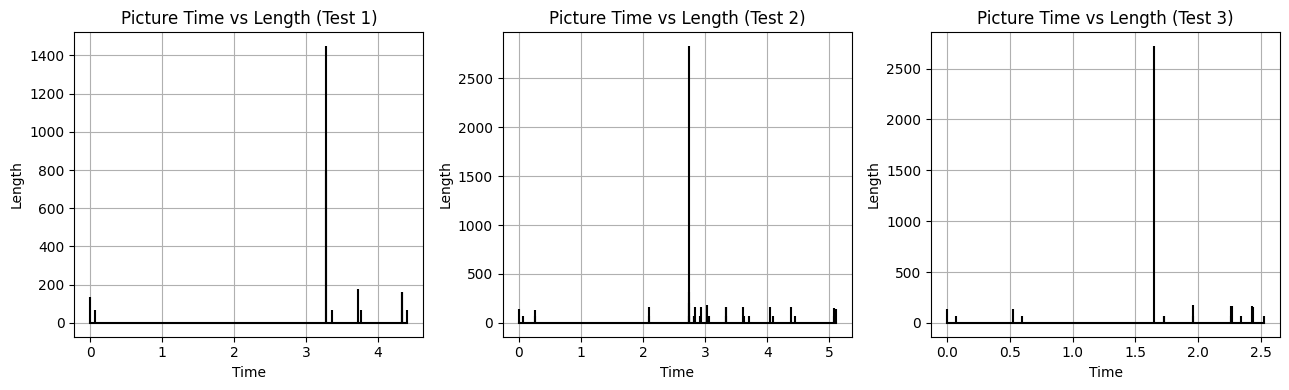

In [412]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4)) 

test1_time = picture_check1['Time']
test1_length = picture_check1['Length']
ax1.stem(test1_time, test1_length, linefmt ='black', markerfmt = '', basefmt='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Length')
ax1.set_title('Picture Time vs Length (Test 1)')
ax1.grid()


test2_time = picture_check2['Time']
test2_length = picture_check2['Length']
ax2.stem(test2_time, test2_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Length')
ax2.set_title('Picture Time vs Length (Test 2)')
ax2.grid()

test3_time = picture_check3['Time']
test3_length = picture_check3['Length']
ax3.stem(test3_time, test3_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax3.set_xlabel('Time')
ax3.set_ylabel('Length')
ax3.set_title('Picture Time vs Length (Test 3)')
ax3.grid()

fig.tight_layout()
plt.show()

From the experiment we can conclude that any packets with size less than 200 bytes are considered noise and removed from the dataset.<br> This filtered out the numerous small packets resulting from background chatter.

The figure below visualizes the packet reception times and sizes after applying this noise filtration. <br>By removing the small noisy packets, the packets related to the voice messages of interest become more visible.<br> The gaps between these columns represent the intervals between voice message send events, which are more apparent after noise filtering.<br>

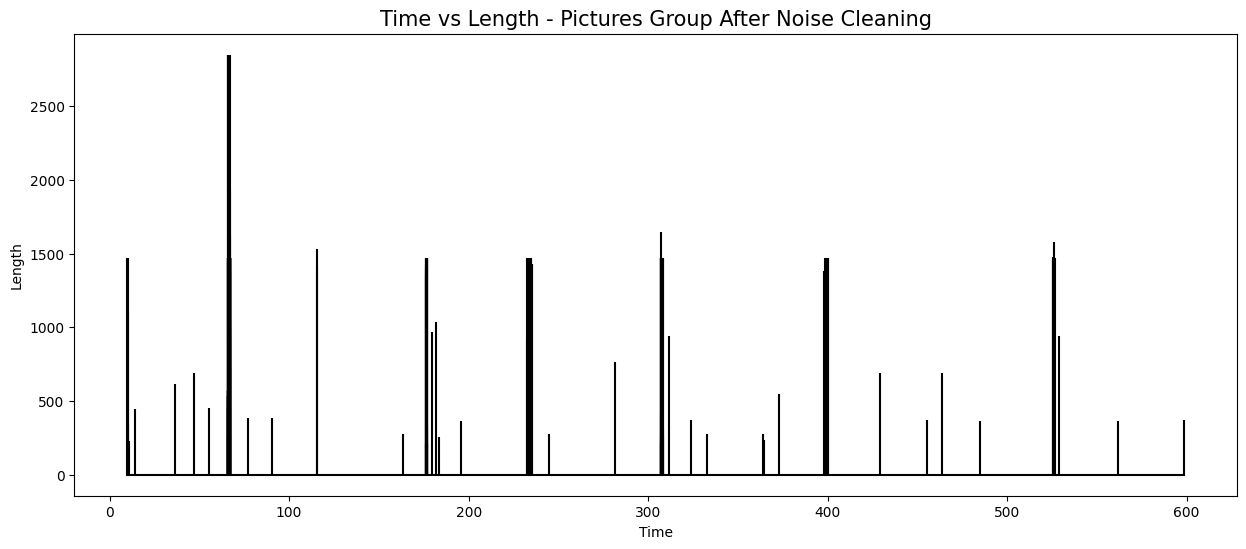

In [413]:
pictures_data = pictures_data.loc[pictures_data['Length'] > 200] 
plot_graph(pictures_data,'Time vs Length - Pictures Group After Noise Cleaning')

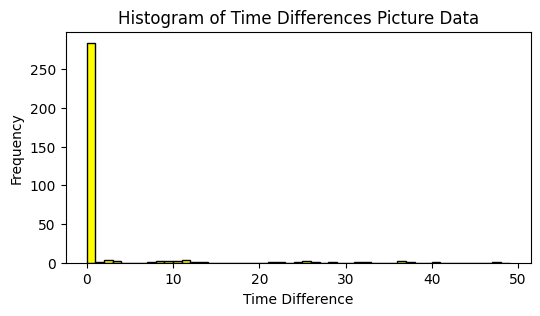

In [450]:
plot_hist(pictures_data, 50, 'Histogram of Time Differences Picture Data')



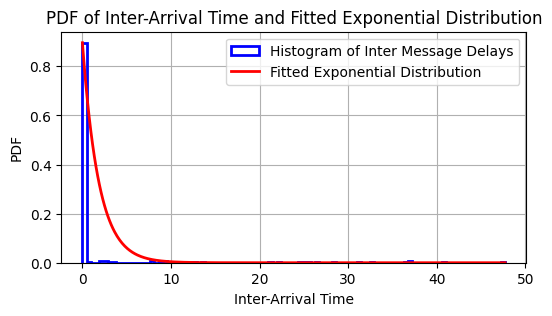

In [415]:
bin_edges, pdf = compute_pdf(pictures_data, bins=100)
visualize_interarrival_pdf(pictures_data, bin_edges, pdf)

### Video Group 

In [416]:
video_data = pd.read_csv("../resources/Video Group/video_data.csv", encoding='latin-1')
unfiltered_data = video_data
video_data = video_data.loc[
    (video_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (video_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
video_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
3,26,29.038825,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=73 Ack=71 Win=1649 Len...
4,27,29.121224,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
6,40,48.680053,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,311,Application Data
10,44,49.065612,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=368 Ack=145 Win=1649 L...
...,...,...,...,...,...,...,...
855,1238,656.342139,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
857,1240,657.486213,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,337,Application Data
860,1243,657.797337,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=63462 Ack=14808 Win=16...
861,1245,660.937724,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,181,Application Data


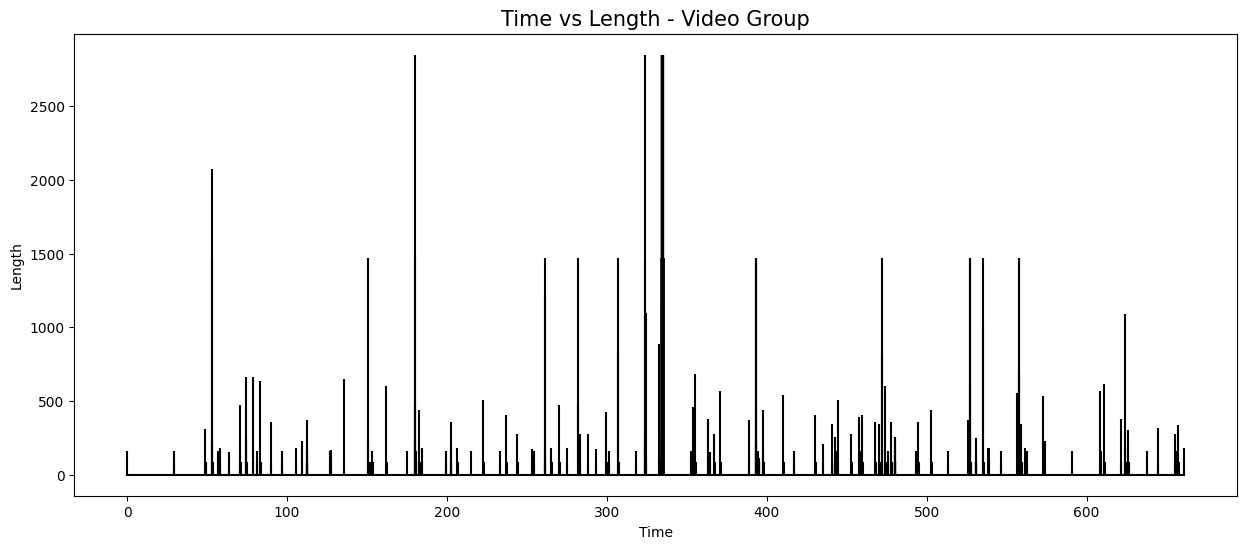

In [417]:
plot_graph(video_data,'Time vs Length - Video Group')

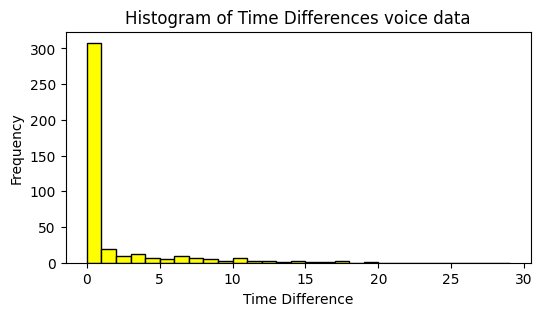

In [453]:
plot_hist(video_data,30, 'Histogram of Time Differences voice data')

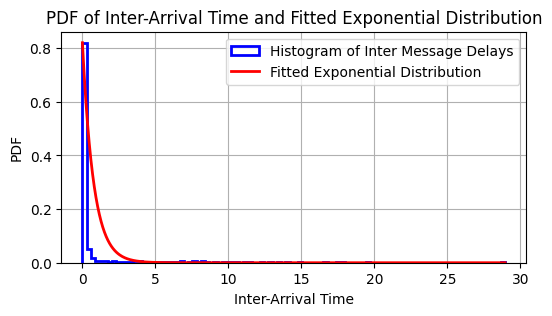

In [454]:
bin_edges, pdf = compute_pdf(unfiltered_data, bins=100)
visualize_interarrival_pdf(unfiltered_data, bin_edges, pdf)

*To characterize how video packets are transmitted, we performed an experiment where the same video file was sent repeatedly.<br>
The video file was sent a total of 3 times, with 40 seconds of idle time in between each sending.<br>*
*This allows us to observe how the packet sizes and timing behave for subsequent transmissions of the same file.<br>*

*By repeating the transmission of the same file, we can analyze metrics like the distribution of packet sizes and intervals for a video file.<br> The idle time between sends allows us to clearly separate the packet information for each transmission.*

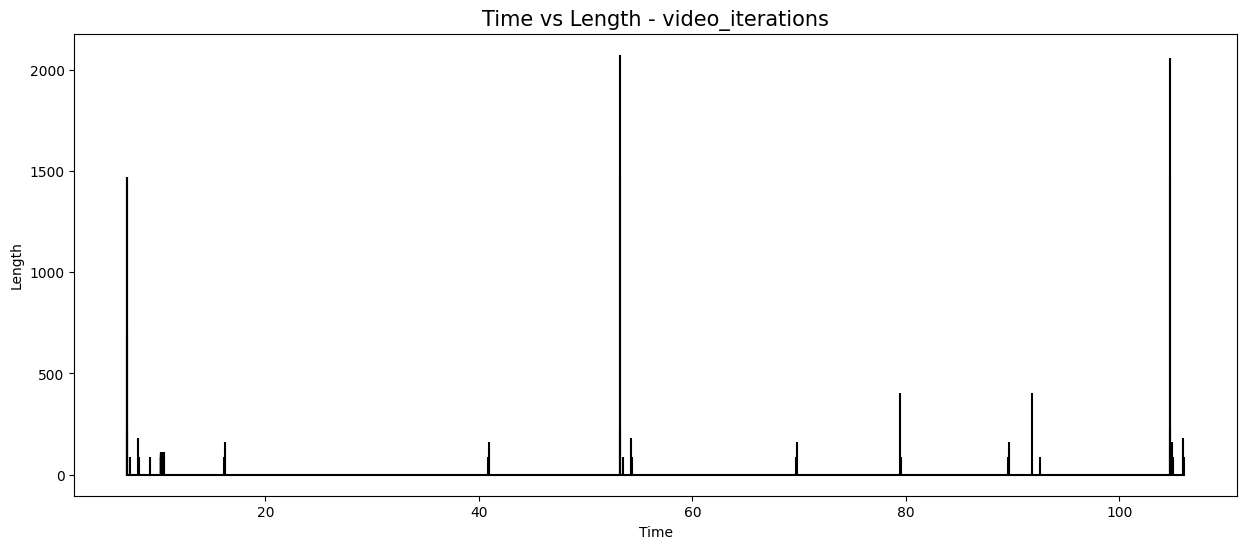

In [420]:
video_iterations = pd.read_csv("../resources/Video Group/same_video_iterations.csv", encoding='latin-1')
video_iterations = video_iterations.loc[
    (video_iterations['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (video_iterations['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]
plot_graph(video_iterations, 'Time vs Length - video_iterations')

### Voice Group 

In [421]:
voice_data = pd.read_csv("../resources/Adiuo Group/adiuo_data.csv")
unfiltered_voice = voice_data
# voice_data = voice_data.loc[
#     (voice_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
#     (voice_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
# ]
voice_data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,6,1.123370,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,181,Application Data
1,7,1.123407,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:c8:face:b00c:0:167,TCP,88,39412 > 443 [ACK] Seq=1 Ack=94 Win=4404 Len=...
2,8,1.128191,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:c8:face:b00c:0:167,TLSv1.2,180,Application Data
3,9,1.209475,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=94 Ack=93 Win=1703 Len...
4,13,3.363043,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:c8:face:b00c:0:167,TLSv1.2,158,Application Data


*The dataset contains recordings of voice messages from a specific group chat. Each voice recording lasted approximately 40 seconds on average. During the recordings, there was significant background noise caused by other simultaneous group chats on the messaging platform. This unrelated chat traffic resulted in many small extraneous packets in the recordings.*

*Upon inspection of the recordings, clusters of wider columns cn be observed. These columns correspond to packets containing voice messages from the target group chat. The wider columns represent instances where multiple voice messages were sent in rapid succession, resulting in a cluster of voice message packets. The gaps between the columns are the intervals between different voice messages being sent.*

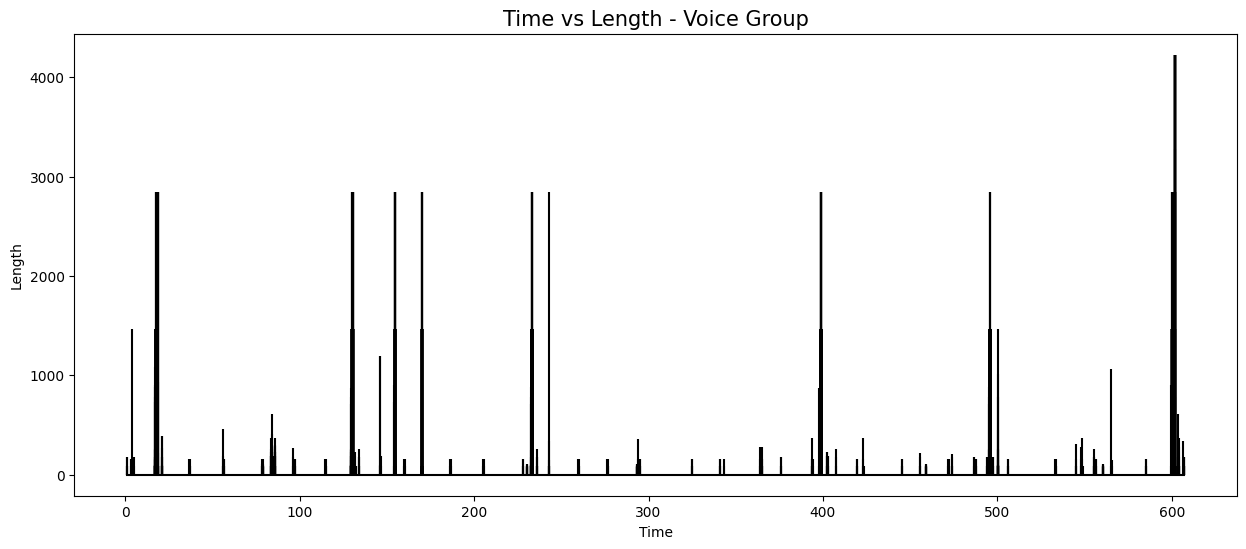

In [422]:
plot_graph(voice_data, 'Time vs Length - Voice Group')

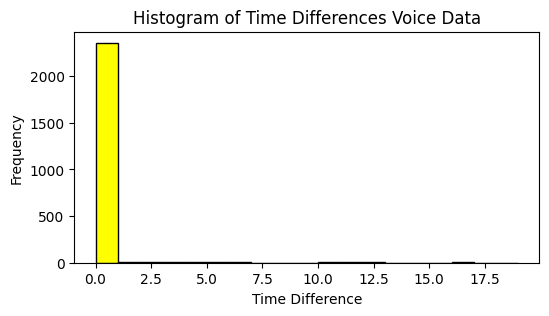

In [456]:
plot_hist(voice_data , 20, 'Histogram of Time Differences Voice Data')

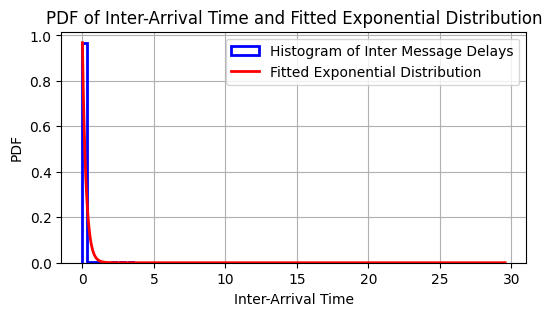

In [425]:
bin_edges, pdf = compute_pdf(voice_data, bins=100)
visualize_interarrival_pdf(voice_data, bin_edges, pdf)

במהלך העבודה על קבוצת הטקסט הבחנו במשהו שהיה נראה לה קצת מוזר וחשבנו לבדוק אותו קצת יותר לעומק. בגרף המתאר את האורכים של הפאקטות אל מול הזמן בקבוצת הוידאו, ניתן לראות שהגודל הממצוע של פאקטה הוא באזור 1000. מצד שני, בקבוצת השמע, ניתן לראות בגרף שהאורך הממצוע של פאקטה הוא בערך 

In [463]:
print(pd.DataFrame(voice_data.Length.describe()).T,'\n\n')


pd.DataFrame(video_data.Length.describe()).T

         count        mean        std   min   25%    50%     75%     max
Length  2420.0  851.176033  945.20989  76.0  88.0  181.0  1468.0  4228.0 




,count,mean,std,min,25%,50%,75%,max
Length,405.0,615.530864,728.077648,88.0,88.0,193.0,1468.0,2848.0


### Text Group

In [426]:
text_data = pd.read_csv("../resources/Text Group/text_data.csv", encoding='latin-1')
unfiltered_text = text_data
text_data = text_data.loc[
    (text_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (text_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
text_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,176,Application Data
2,3,0.095351,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=89 Ack=73 Win=1537 Len...
3,5,7.679440,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,429,Application Data
5,7,7.766057,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=430 Ack=173 Win=1537 L...
6,8,7.767061,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,407,Application Data
...,...,...,...,...,...,...,...
1812,2201,627.309683,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=36475 Ack=26874 Win=16...
1814,2203,627.309782,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,424,"Application Data, Application Data"
1816,2205,627.718916,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,229,Application Data
1820,2209,627.800928,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=38332 Ack=26974 Win=16...


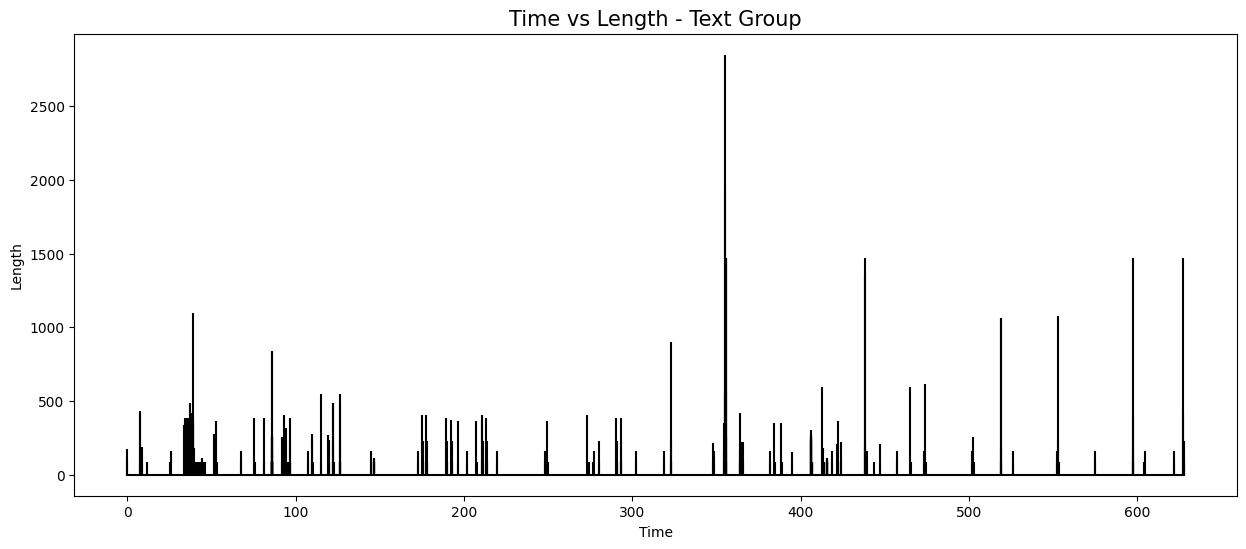

In [427]:
plot_graph(text_data, 'Time vs Length - Text Group')

*To determine which data can be considered noise and filtered out,<br>
we conducted an experiment where we recorded the transmission of the smallest message size within the group.<br>
This experiment was performed twice, in two separate trials.*

*The data graphs from the experiment showed that any packets with a size less than 200 bytes were extraneous to the message transmission.<br> Based on these results, we can conclude that packets under 200 bytes can be assumed to be network noise unrelated to the core messages.<br> Therefore, packets smaller than 200 bytes can be safely filtered out without losing meaningful message data.*

In [428]:
smallest_text_check1 = pd.read_csv("../resources/Text Group/smallest_text_data_first.csv", encoding='latin-1')
smallest_text_check1 = smallest_text_check1.loc[
    (smallest_text_check1['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (smallest_text_check1['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]
smallest_text_check2 = pd.read_csv("../resources/Text Group/smallest_text_data_second.csv", encoding='latin-1')
smallest_text_check2 = smallest_text_check2.loc[
    (smallest_text_check2['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (smallest_text_check2['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]

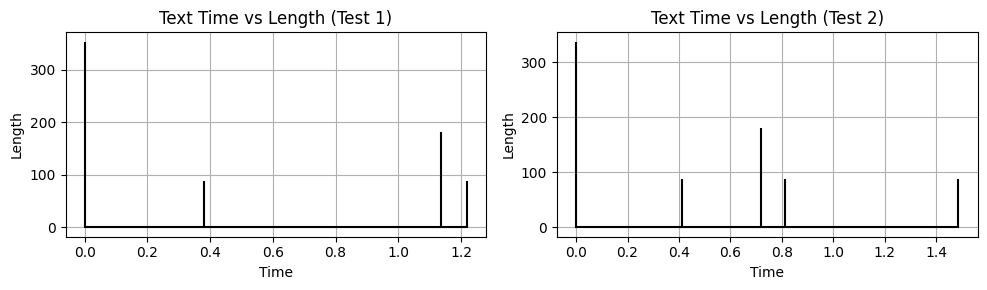

In [429]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3)) 

test1_time = smallest_text_check1['Time']
test1_length = smallest_text_check1['Length']
ax1.stem(test1_time, test1_length, linefmt ='black', markerfmt = '', basefmt='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Length')
ax1.set_title('Text Time vs Length (Test 1)')
ax1.grid()

test2_time = smallest_text_check2['Time']
test2_length = smallest_text_check2['Length']
ax2.stem(test2_time, test2_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Length')
ax2.set_title('Text Time vs Length (Test 2)')
ax2.grid()
fig.tight_layout()
plt.show()

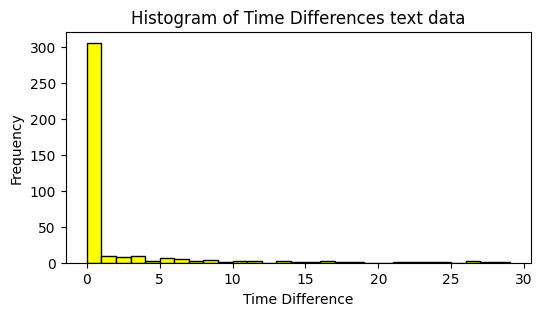

In [460]:
plot_hist(text_data, 30, 'Histogram of Time Differences text data')

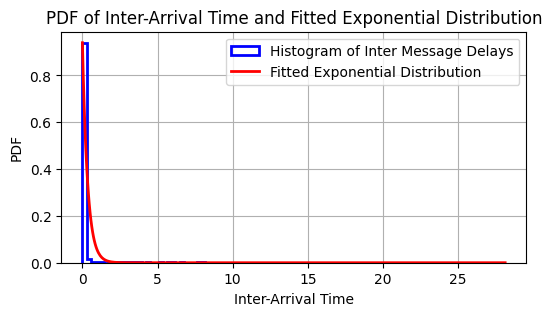

In [431]:
bin_edges, pdf = compute_pdf(unfiltered_text, bins=100)
visualize_interarrival_pdf(unfiltered_text, bin_edges, pdf)

## Mix data

In [432]:
mix_data = pd.read_csv("../resources/Mix data Group/mix_data.csv", encoding='latin-1')
unfiltered_mix = mix_data
mix_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,230,Application Data
1,2,0.000041,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:1c3:face:b00c:0:167,TCP,88,44122 > 443 [ACK] Seq=1 Ack=143 Win=2536 Len...
2,3,0.413747,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,163,Application Data
3,4,0.520912,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 44122 [ACK] Seq=143 Ack=76 Win=866 Len...
4,7,6.629572,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,158,Application Data
...,...,...,...,...,...,...,...
3165,3794,827.442656,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 44122 [ACK] Seq=111449 Ack=37156 Win=1...
3166,3795,828.993511,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,158,Application Data
3167,3796,829.072638,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 44122 [ACK] Seq=111449 Ack=37226 Win=1...
3168,3797,829.153363,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data


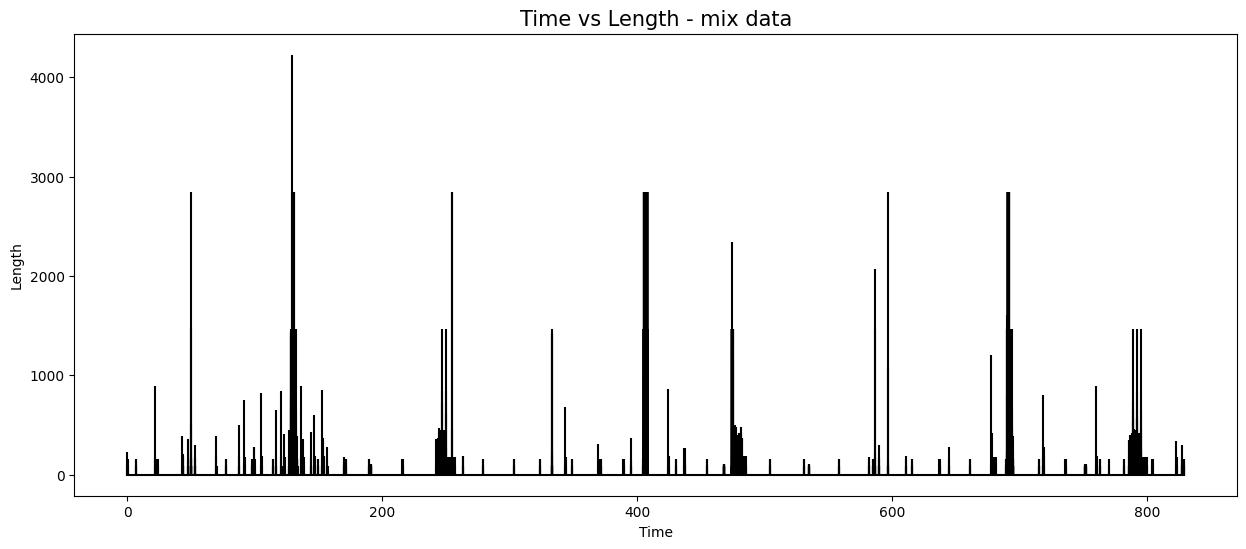

In [433]:
mix_data_filter = mix_data.loc[
    (mix_data['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (mix_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]

plot_graph(mix_data, 'Time vs Length - mix data')

*In order to characterize the packet patterns when sending different data types, we conducted an experiment transmitting a known sequence of media. The sequence consisted of one video file, followed by a group of photos, and then a series of short text messages.*  <br>*This sequence was transmitted a total of three times.*

*The figure shows the unlabeled raw packet data in red, with packets transmitted from WhatsApp server to our computer highlighted in red.* 
#### (?)Upon close inspection, identifiable patterns emerge corresponding to each data type. 


*The video file is usually expressed in several large packets. The group of photos similarly shows up as a cluster of large red packets following each video segment. Finally, the short text messages appear as a dense block-like bundle of smaller red packets after each photo bundle.*

*By coloring a known sequence, we can start to recognize data-type-specific patterns in the raw packet streams. Videos yield large, sparse red packets while photos cluster into dense red blocks. Short textual messages emerge as a red block-like bundle of smaller packets. With further analysis, these fingerprints could help identify unknown data types and sequences within messy raw packet streams.*

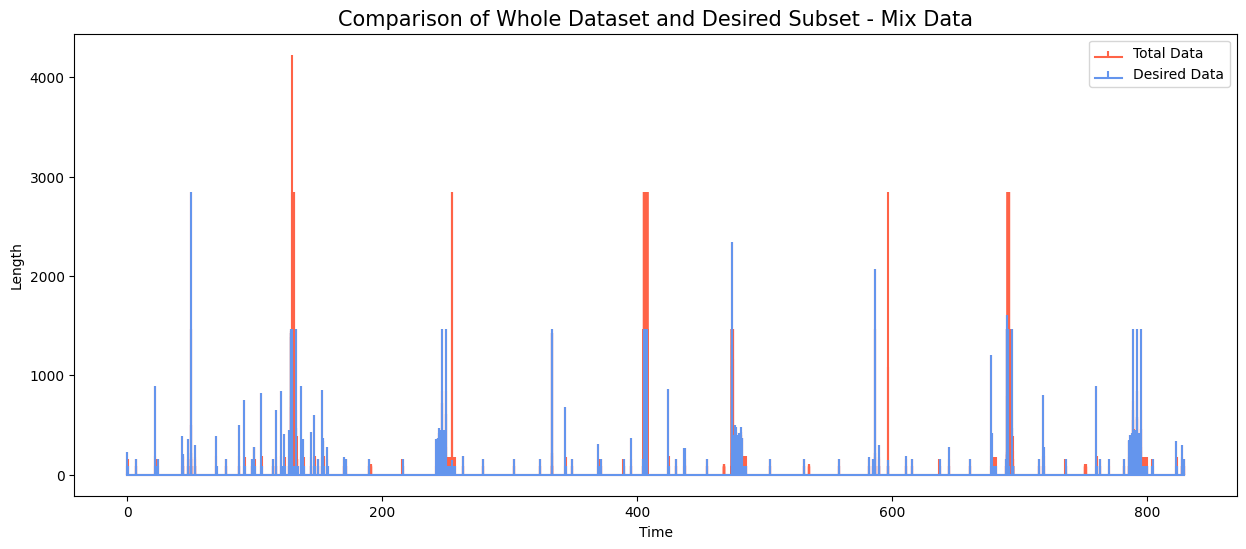

In [447]:
plot_main_and_sub_graph(mix_data, mix_data_filter, 'Comparison of Whole Dataset and Desired Subset - Mix Data','Total Data','Desired Data')

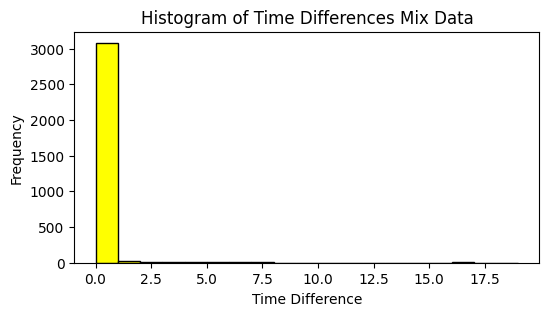

In [462]:
plot_hist(mix_data, 20, 'Histogram of Time Differences Mix Data')

### Text with Spotify at the backroud

Having identified distinctive patterns for text messages in the clean dataset, we next introduced intentional background noise to determine if the patterns persist. Specifically, Spotify audio streaming was used to generate noisy packet data while simultaneously transmitting and recording text messages.

Despite the addition of significant background noise, inspection of the data reveals the reappearance of the characteristic text message pattern. As before, the text messages manifest as a dense block-like bundle of smaller red packets distinct from the noise. This indicates that the fingerprint we identified for text messages is robust to even heavy amounts of background traffic noise.

Moving forward, we can use these robust text message fingerprints to identify and extract relevant packets even if there is substantial unrelated noise from activities like music streaming. The persistence of the patterns suggests it may be possible to detect various message types amidst noisy transmission environments where extraneous packets are interspersed. More testing is needed to determine if other data types like photos maintain their identifiable marks when noise is introduced.

In [438]:
text_with_spotify = pd.read_csv("../resources/Mix data Group/text_with_spotify_data.csv", encoding='latin-1')
text_with_spotify

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,157.240.221.60,192.168.1.12,TLSv1.2,851,Application Data
1,2,0.000049,192.168.1.12,157.240.221.60,TCP,68,43168 > 443 [ACK] Seq=1 Ack=784 Win=967 Len=...
2,3,2.218931,192.168.1.12,157.240.221.60,TLSv1.2,137,Application Data
3,4,2.295179,157.240.221.60,192.168.1.12,TCP,68,443 > 43168 [ACK] Seq=784 Ack=70 Win=549 Len...
4,5,2.379339,157.240.221.60,192.168.1.12,TLSv1.2,139,Application Data
...,...,...,...,...,...,...,...
24974,26232,816.559333,2a00:a040:0:4:face:b00c:3333:7020,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,"443 > 33356 [PSH, ACK] Seq=158579 Ack=1199 W..."
24975,26233,816.559338,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a00:a040:0:4:face:b00c:3333:7020,TCP,88,33356 > 443 [ACK] Seq=1199 Ack=159959 Win=23...
24976,26234,816.559955,2a00:a040:0:4:face:b00c:3333:7020,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.3,2669,"Application Data, Application Data"
24977,26235,816.559958,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,2a00:a040:0:4:face:b00c:3333:7020,TCP,88,33356 > 443 [ACK] Seq=1199 Ack=162540 Win=24...


In [445]:
text_with_spotify_filter = text_with_spotify.loc[
    ((text_with_spotify['Source'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9') & 
    (text_with_spotify['Destination'] == '2a03:2880:f258:c8:face:b00c:0:167'))|
    (text_with_spotify['Destination'] == '192.168.1.12')
]

spotify_packets = text_with_spotify.loc[
    (text_with_spotify['Source'] == '2600:1901:1:c36::')]

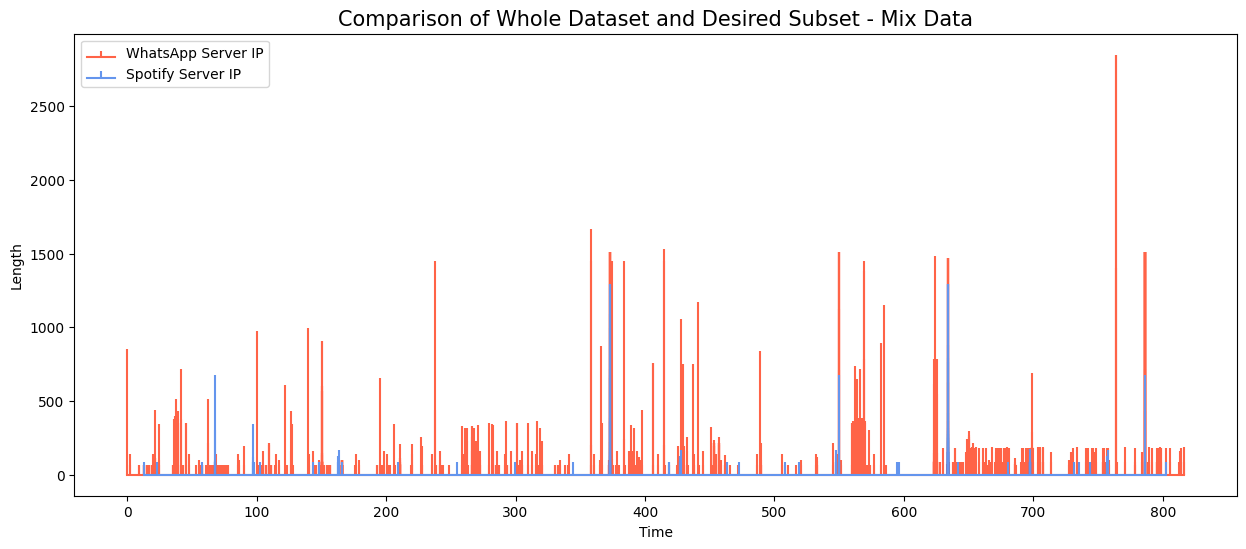

In [446]:
plot_main_and_sub_graph(text_with_spotify_filter,spotify_packets, 'Comparison of Whole Dataset and Desired Subset - Mix Data' ,'WhatsApp Server IP','Spotify Server IP')

From this packet capture, we can see there was very intensive activity on the WhatsApp servers during the recording. The WhatsApp group we recorded was extremely busy with messages, which is clearly visible in the graph.

Additionally, we expected the Spotify streaming to generate more significant noise. However, in comparison to the server activity, the Spotify noise is relatively insignificant. The bulk of the traffic stems from the barrage of messages within the busy WhatsApp group chat.

This dataset provides an example of WhatsApp traffic during periods of heavy chat activity. The volume of messages being exchanged results in pronounced server traffic that overshadows background noise sources like music streaming. Analyzing busy versus idle chat patterns could provide insights into WhatsApp bandwidth usage and server loads under different use cases.

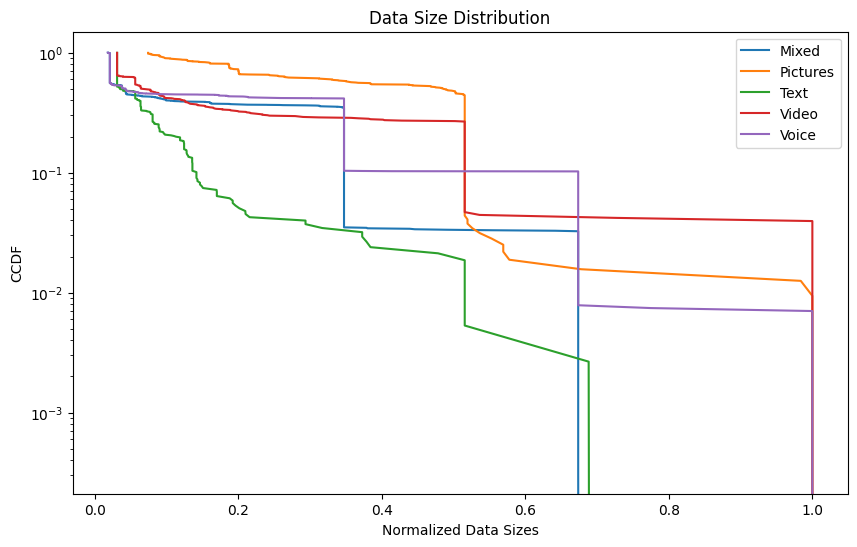

In [448]:

def compute_complementary_cdf(data_col):
    """
    Calculate the Complementary Cumulative Distribution Function (CCDF) for a given column of data.
    
    Args:
        data_col (array-like): The data column for which to calculate CCDF.
        threshold (float): A threshold value for normalization.
        
    Returns:
        normalized_data (array-like): Normalized values of the data.
        ccdf_vals (array-like): CCDF values corresponding to the data.
    """
    # Sort and normalize the data
    sorted_data = np.sort(data_col)
    normalized_data = sorted_data / max(sorted_data)
    
    # Compute CCDF
    cdf_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ccdf_vals = 1 - cdf_vals
    
    return normalized_data, ccdf_vals

def plot_ccdf_for_datasets(data_list, data_labels):
    """
    Plot Complementary Cumulative Distribution Function (CCDF) for a list of datasets.
    
    Args:
        data_list (list): List of datasets to plot.
        data_labels (list): Labels corresponding to each dataset.
    """
    
    plt.figure(figsize=(10, 6))
    
    for dataset, label in zip(data_list, data_labels):
        normalized_data, ccdf_data = compute_complementary_cdf(dataset['Length'])
        plt.plot(normalized_data, ccdf_data, label=label)
    
    plt.yscale('log')
    plt.xlabel('Normalized Data Sizes')
    plt.ylabel('CCDF') 
    plt.title('Data Size Distribution')
    plt.legend(loc="upper right")
    plt.show()

# Example usage
datasets = [mix_data, pictures_data, text_data, video_data, voice_data]  # List of your datasets
labels = ['Mixed', 'Pictures', 'Text', 'Video', 'Voice' ]  # Corresponding labels
plot_ccdf_for_datasets(datasets, labels)